In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import scipy as sp
import matplotlib
from matplotlib import animation, rc
from sklearn.neighbors import NearestNeighbors
from IPython.display import HTML
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D


In [2]:
class mdata: # Defines class for a set of data values
    def __init__(self,Data,theta = False): #data is numpy array of points that lie on some manifold
        self.data = Data #The data contains some data "sampled from a manifold". Simply consists of points in R^n
        self.theta = theta #This parameter is necessary to plot and only applies to a circle
        self.identity = np.identity(self.data.shape[0]) #Identity matrix of the size of data
        self.length = len(self.data) #This the number of samples of the manifold we have
        return

    def graph(self):
        return cdist(self.data,self.data) #cdist operates the same as pdist2 in matlab. It returns a matrix whose
                                          #(i,j) entry is the Euclidean distance between points i and j
                                
    def kernel(self,eps):
        graph = self.graph() # The kernel magnifies the distances in the weighted graph
        return np.exp(np.square(graph)/(-2)/eps/eps)

    def dmatrix(self,eps): #The diagonal entries in the dmatrix correspond to the row sums of the kernel
        return np.diag(np.sum(self.kernel(eps),axis=1))

    def laplacian(self,eps): #Returns the unnormalized graph Laplacian
        D = self.dmatrix(eps)
        K = self.kernel(eps)
        L = (D-K)/eps**2
        return L

    def leftright(self,eps): #Does a normalization for non-uniform sampling 
        x = np.shape(self.data)
        Ldim = (x[0],x[0])
        I = np.identity(Ldim[0])
        K = self.kernel(eps)
        D = self.dmatrix(eps)
        Dinv = np.linalg.inv(D)
        Ktilde = K.dot(Dinv)
        Dtilde = np.diag(np.sum(Ktilde,axis=1))
        Dtildeinv = np.linalg.inv(Dtilde)
        #Left normalization
        Khat = Dtildeinv.dot(Ktilde)
        Lhat = (I - Khat)/(eps**2)
        return Lhat

    def symmetric(self,eps):
        x = np.shape(self.data) #Returns a symmetric matrix so we can use a faster eigensolver
        Ldim = (x[0],x[0])
        I = np.identity(x[0])
        K = self.kernel(eps)
        D = self.dmatrix(eps)
        Dinv = np.linalg.inv(D)
        Ktilde = K.dot(Dinv)
        Ktilde = Dinv.dot(Ktilde)
        Dtilde = np.diag(np.sum(Ktilde,axis=1))
        Dtildeinv = np.linalg.inv(Dtilde)

        Dhalf = np.power(np.diag(Dtildeinv),0.5)
        Dhalf = np.diag(Dhalf)
        #Symmetric normalization

        Ktilde = Dhalf.dot(Ktilde)
        Ktilde = Ktilde.dot(Dhalf)
        Lsym = I - Ktilde
        
        Lsym = (Lsym + Lsym.T)/2
        Lsym = Lsym/(eps**2)
        
        return(Lsym,Dhalf)

    
    def eigs(self,eps = .003): #Returns the eigenvalues using the symmetric normalization
        emach = np.finfo(float).eps
        
        Lsym,Dhalf = self.symmetric(eps)
        eigenValues, eigenVectors = np.linalg.eigh(Lsym)
        idx = eigenValues.argsort()
        eigenValues = eigenValues[idx]
        eigenVectors = eigenVectors[:,idx]
        return eigenValues, Dhalf.dot(eigenVectors)
    
    def eigs2(self,eps=.003): #nonsymmetric eigenvalue 
        L = self.leftright(eps)
        eigenValues, eigenVectors = sp.linalg.eig(L)
        idx = eigenValues.argsort()
        eigenValues = eigenValues[idx]
        eigenVectors = eigenVectors[:,idx]
        return np.real(eigenValues), np.real(eigenVectors)     

    def eigplot(self,n,eps): #Plots the eigenfunctions of the Laplacian 
        #if not self.theta:
         #   return
        eigenValues,eigenVectors = self.eigs(eps) 
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=0.3)
        N = eigenVectors.shape[1]
        for i in range(n):
            #plt.subplot(np.ceil((N+1)/2),2,i+1)
            plt.figure()
            plt.grid(1)
            plt.plot(eigenVectors[:,i])
            plt.title(r"%d eigenfunction of L" %i)
            plt.xlabel(r"t")
            plt.ylabel(r"$\Delta_g \vec{f}$")
        return
    
    def NonUniform_spec_solve_vec(self,t,f0,eps = .003): #Will solve the heat equation for all time vectors in t, and return a matrix
                                                     # "sol" whose ith column is the solution for t[i]. For solving heat equation
        N = self.length
        cols = len(t)
        sol = np.empty([N,cols])
        V,U = self.eigs(eps)
        D = self.dmatrix(eps)
        K = self.kernel(eps) 
        Dinv = sp.linalg.inv(D)
        Ktilde = K.dot(Dinv)
        Ktilde = Dinv.dot(Ktilde)
        Dtilde = np.diag(np.sum(Ktilde,axis=1))
        E = ((1/N)*(U.T).dot(Dtilde)).dot(U)
        Einv = sp.linalg.inv(E)
        Einv = np.diag(np.sqrt(np.diag(Einv)))  #The matrix multiplication is done in several steps but it will save some 
        Utilde = U.dot(Einv)  #recomputation
        for i in range(cols):
            v1 = np.exp(-1*(t[i])*V)
            v1 = np.diag(v1)
            fhat = (Utilde.T.dot(Dtilde)).dot(f0)/N
            temp1 = Utilde.dot(v1)
            sol[:,i] = temp1.dot(fhat)  
        return sol

    def NonUniform_spec_solve(self,t,f0,eps = .003): #Will solve the heat equation for all time vectors in t, and return a matrix
                                                     # "sol" whose ith column is the solution for t[i] 
        N = self.length
        V,U = self.eigs(eps)
        D = self.dmatrix(eps)
        K = self.kernel(eps) 
        Dinv = sp.linalg.inv(D)
        Ktilde = K.dot(Dinv)
        Ktilde = Dinv.dot(Ktilde)
        Dtilde = np.diag(np.sum(Ktilde,axis=1))
        E = ((1/N)*(U.T).dot(Dtilde)).dot(U)
        Einv = sp.linalg.inv(E)
        Einv = np.diag(np.sqrt(np.diag(Einv)))  #The matrix multiplication is done in several steps but it will save some 
        Utilde = U.dot(Einv)  #recomputation
        v1 = np.exp(-1*(t)*V)
        #v1 = np.exp(-1*t*V - t*np.square(V)/(1000**2))
        v1 = np.diag(v1)
        fhat = (Utilde.T.dot(Dtilde)).dot(f0)/N
        temp1 = Utilde.dot(v1)
        sol = temp1.dot(fhat)  
        print("max eigenvalue: ", np.max(V))
        return sol
    



In [3]:
def circle_data(Ntheta=500,Nt=10,tmax=10,shape = (1,1),plot = 0): #Creates test data for an ellipse using Ntheta uniform samples on the circle
                                                    #and Nt uniform samples in time
    xstretch = shape[0]
    ystretch = shape[1]
    xs = 2*np.pi*np.linspace(1/Ntheta,1,Ntheta) #Even grid from 0 to 2pi
    theta = xs
    #theta = xs - np.sin(xs)/2  # Non-Uniform theta grid
    t = np.linspace(0,tmax,Nt)             
    if plot == 1:
        plt.figure()
        plt.plot(xs,theta)
        plt.title(r"Grid Distribution")
        plt.xlabel(r"$\theta$")
        plt.ylabel(r"$f \left (\theta \right )$")

    xn = xstretch*np.cos(theta); yn = ystretch*np.sin(theta);  # Defines data
    xn = xn.reshape(Ntheta,1); yn = yn.reshape(Ntheta,1)
    
    if plot ==1: 
        plt.figure()
        plt.scatter(xn,yn)
        plt.title(r"Data on Manifold")
        plt.xlabel(r"$x_i(\theta)$")
        plt.ylabel(r"$y_i(\theta)$")
    
    
    A = np.concatenate((xn,yn),axis = 1)
    X = mdata(A,theta)
    return X,theta,t


def sphere_data(Npoints, Nt, tmax, radius=1,plot = 0,initial= None):
    t = np.linspace(0,tmax,Nt)
    xx = np.linspace(0,1,Npoints**2)
    phi = np.pi*np.linspace(1/Npoints,1,Npoints) #Even grid from 0 to 2pi
    theta = 2*np.pi*np.linspace(1/Npoints,1,Npoints) #Even grid from 0 to 2pi
    PHI, THETA = np.meshgrid(phi,theta)
    x = radius*np.sin(PHI)*np.cos(THETA)
    y = radius*np.sin(PHI)*np.sin(THETA)
    z = radius*np.cos(PHI)
    x = x.reshape((Npoints**2,1))
    y = y.reshape((Npoints**2,1))
    z = z.reshape((Npoints**2,1))
    A = np.concatenate((x,y,z),axis=1)
    if plot ==1:
        fig = plt.figure()
        ax = fig.gca(projection = '3d') 
        ax.scatter(x,y,z,c = initial,cmap = "coolwarm", vmin = initial.min(), vmax = initial.max())
        plt.title(r"Initial Sphere Data")
        ax.set_xlabel(r'$X$')
        ax.set_ylabel(r'$Y$')
        ax.set_zlabel(r'$Z$')
    plt.show()
    X = mdata(A)
    return X,t


In [4]:
def sphere_initial_conditions(Npoints):
    fo = np.ones(Npoints**2)
    fo[100:200] = 0
    return fo

In [5]:
def bandwidthFinder(Data,p,k = False,minkowski_parameter = 2):
    """A function that uses k nearest neighbors to find an epsilon to construct a graph Laplacian:
   Data is either a matrix of points (m x n) ([x_00,x_10,..,x_m0].....[x_0n,x_1n,....x_mn] or 
   k is the number of nearest neighbors, default set to ceil(log(N))
   p is the number of points to sample randomly around the manifold
   The optional minkowski parameter is for other metrics of distance 
   """
    A = Data.data
    
    N = len(A)

    if  k:
        k = k
  
    else:
        k = int(np.ceil(np.log(N)))

    ind = np.random.randint(N,size = p) #This will choose 'p' random indices 
    choosePoints = A[ind] #These are the points to choose from.
    neigh = NearestNeighbors(n_neighbors = k, metric ='minkowski', p = minkowski_parameter).fit(A)
    dist, ind = neigh.kneighbors(choosePoints) #Returns the distances
    distance_sum = np.sum(dist)/k #returns the average distances
    epsilon = np.sum(distance_sum)/p
    return epsilon
    
                             

In [6]:
def polygon_normalization(data): #Can provide a matrix or an mdata object consisting of datapoints in R^n
    """Uses the shoelace formula to find an approximation of the area of the 2-D manifold"""
    if type(data) == mdata:
        A = data.data
    elif type(data) == np.ndarray:
        A = data
    else:
        input_type = str(type(data))
        raise TypeError("Incorrect data type: %s"%input_type)
    #Area Approximation
    Atemp = np.empty((A.shape[0] + 1, A.shape[1])) #Setup for shoelace formula
    Atemp[0:-1,:] = A
    Atemp[-1,:] = A[0]
    A = Atemp
    xadd = A[0:-1,0]; yadd = A[1::,1];
    xsub = A[1::,0]; ysub = A[0:-1,1];
    area = xadd.dot(yadd) - xsub.dot(ysub) # dot products 
    return area/2
    

In [7]:
def GeometricFlow(manifold_data,T,dt): #Runs a Geometric flow for time values of t. data is a mdata object
    data = manifold_data
    N = data.length
    #solx = np.empty((N,len(t)))
    #soly = np.empty((N,len(t)))
    solx = np.empty((N,T))
    soly = np.empty((N,T))
    A = data.data
    tempx = A[:,0]; tempy = A[:,1]
    npoints = int(np.ceil(np.sqrt(data.length)))
    initial_area = polygon_normalization(data)
    print(initial_area)
    for i in range(T):
        band_eps = bandwidthFinder(Data = data, p = npoints)
        #if band_eps < 10**-5:
        #    band_eps = 10**-5
        #tempx = data.NonUniform_spec_solve((t[i+1]-t[i]),f0 = tempx,eps = band_eps)
        #tempy = data.NonUniform_spec_solve((t[i+1]-t[i]),f0 = tempy,eps = band_eps)
        tempx = data.NonUniform_spec_solve(dt,f0 = tempx,eps = band_eps)
        tempy = data.NonUniform_spec_solve(dt,f0 = tempy,eps = band_eps)

        area_norm = initial_area/polygon_normalization(data)
        print("norm: ", area_norm)
        print("iteration: ", i)
        print("current_area: ", polygon_normalization(data))
        print("current epsilon: ", band_eps)
        tempx = tempx*(np.sqrt(area_norm))
        tempy = tempy*(np.sqrt(area_norm))
        if i%2 == 0:
            plt.plot(tempx,tempy)
            plt.savefig('p%d'%i)
        solx[:,i] = tempx
        soly[:,i] = tempy
        temp = np.concatenate((tempx.reshape((N,1)),tempy.reshape((N,1))),axis = 1)
        data.data = temp
        

    return solx,soly
        

In [8]:
#Runninge a Gometric Flow for an ellipse and a sphere

<IPython.core.display.Javascript object>


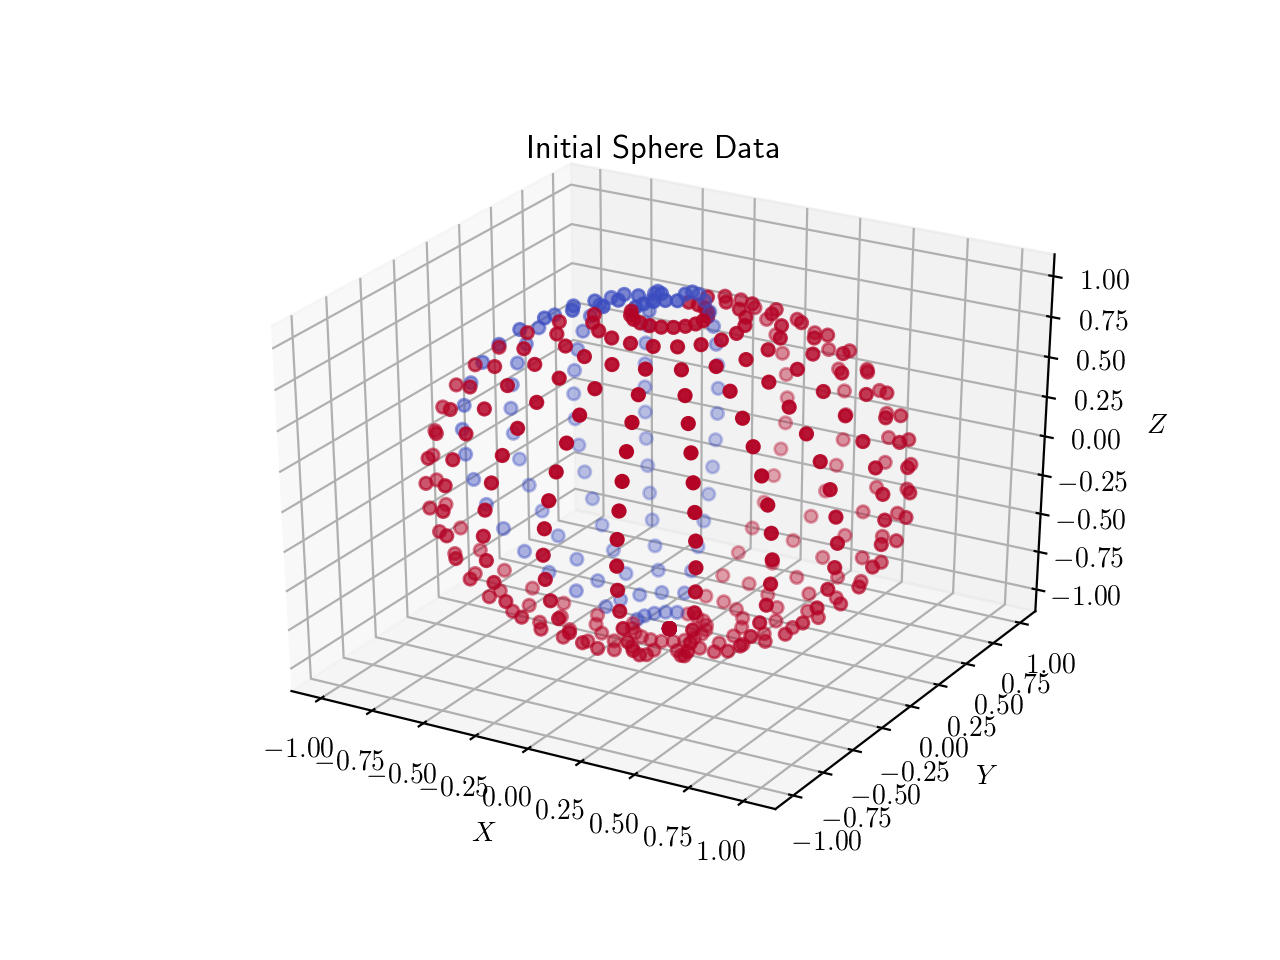

In [9]:
fo = sphere_initial_conditions(20)
Data,t = sphere_data(Npoints=20,Nt=20,tmax=3,radius = 1,plot=1,initial=fo)
A = Data.data


In [10]:
eps_value = bandwidthFinder(Data,p=20,k = False,minkowski_parameter = 2)
fo = sphere_initial_conditions(20)
sol = Data.NonUniform_spec_solve_vec(eps = eps_value,t = t,f0 = fo)

In [11]:
class AnimatedScatter():
    """Animates a Scatter Plot/creates an animated heat map given a solution matrix"""
    def __init__(self, sol,A): #
        self.sol = sol
        self.min = sol.min()
        self.max = sol.max()
        self.xn = A[:,0]
        self.N = len(self.xn)
        self.yn = A[:,1]
        self.zn = A[:,2]
        # Setup the figure and axes...
        self.fig = plt.figure()
        self.ax  = self.fig.gca(projection = "3d")
        #plt.xlabel(r"$\theta$")
        #plt.ylabel(r"$f\left(\theta \right)$")
        #plt.title(r"Heat Flow on a Circle")
        plt.grid()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, init_func = self.setup_plot,interval=5, blit = True,frames=200)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        sol = self.sol 
        self.scat = self.ax.scatter(self.xn,self.yn,self.zn, c = sol[:,0], cmap = "coolwarm",vmin = self.min, vmax = self.max)
        plt.title(r"Heat Flow on a Sphere")
        ax.set_xlabel(r'$X$')
        ax.set_ylabel(r'$Y$')
        ax.set_zlabel(r'$Z$')
        return self.scat,

    def update(self, i):
        plt.cla()
        self.scat = self.ax.scatter(self.xn,self.yn,self.zn, c = sol[:,i], cmap = "coolwarm",vmin = self.min, vmax = self.max)

  
        return self.scat,
    
    def save(self,name,fps,dpi):
        anim2 = self.ani
        anim2.save(name, fps=fps, extra_args=['-vcodec', 'libx264'],dpi = dpi)

    def show(self):
        plt.show()

<IPython.core.display.Javascript object>


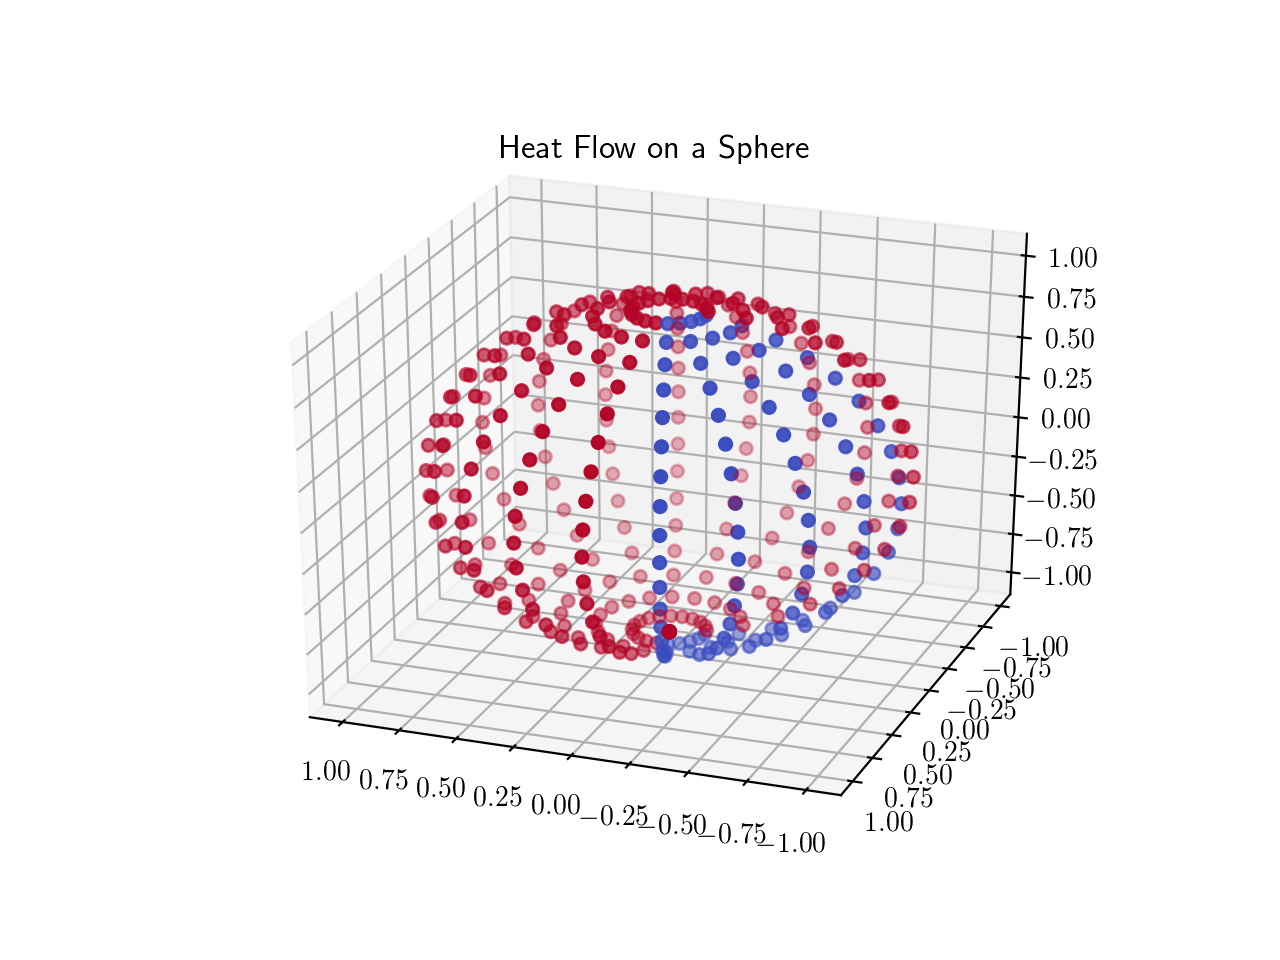

In [12]:
X = AnimatedScatter(sol,A)

In [13]:
import matplotlib as mpl
mpl.matplotlib_fname()

'/Users/Aneesh/anaconda/lib/python3.5/site-packages/matplotlib/mpl-data/matplotlibrc'